<a href="https://colab.research.google.com/github/Joocheol/Financial-Engineering/blob/master/20211124_submodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

In [ ]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

In [ ]:
S0 = 1
K = 1
T = 30/365
r = 0.0
sig = 0.2

M = 1000
N = 30

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [ ]:
np.random.seed(1234)

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

$\Delta_0 (S_0-S_1) + \Delta_1 (S_1-S_2) + \Delta_2 (S_2-S_3) + \cdots + \Delta_{T-1} (S_{T-1}-S_T) + \Delta_T S_T$

In [ ]:
def delta_model(model_name=None):
    price = tf.keras.layers.Input(shape=(1,))
    
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.Dense(1, activation='sigmoid')(delta)

    return tf.keras.Model(inputs=price, outputs=delta, name=model_name)


In [ ]:
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = [price]

hedge_cost = tf.keras.layers.Lambda(lambda x: x*0.0)(price)

for j in range(N):
    delta = delta_model(model_name="delta_"+str(j))(price)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input += [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])

    price = new_price

payoff = tf.keras.layers.Input(shape=(1,), name='payoff')
my_input += [payoff]

cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

$\Delta_0 (S_0-S_1) + \Delta_1 (S_1-S_2) + \Delta_2 (S_2-S_3) + \cdots + \Delta_{T-1} (S_{T-1}-S_T) + \Delta_T S_T$

In [ ]:
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
payoff = np.maximum(S[:,-1]-K, 0)
x = [SS] + [payoff]
y = bscall(S0, K, T, r, sig) * np.ones([M,1])

In [ ]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
hist = model.fit(x,y, batch_size=32, epochs=50, verbose=True, validation_split=0.2)

Epoch 1/50
25/25 [==============================] - 17s 107ms/step - loss: 1.4890e-04 - val_loss: 2.8188e-04
Epoch 2/50
25/25 [==============================] - 1s 25ms/step - loss: 3.2332e-05 - val_loss: 2.8283e-04
Epoch 3/50
25/25 [==============================] - 1s 24ms/step - loss: 3.1170e-05 - val_loss: 2.8100e-04
Epoch 4/50
25/25 [==============================] - 1s 27ms/step - loss: 2.7349e-05 - val_loss: 2.7845e-04
Epoch 5/50
25/25 [==============================] - 1s 26ms/step - loss: 2.2987e-05 - val_loss: 2.7695e-04
Epoch 6/50
25/25 [==============================] - 1s 25ms/step - loss: 2.2143e-05 - val_loss: 2.7377e-04
Epoch 7/50
25/25 [==============================] - 1s 25ms/step - loss: 2.0076e-05 - val_loss: 2.7116e-04
Epoch 8/50
25/25 [==============================] - 1s 25ms/step - loss: 2.7263e-05 - val_loss: 2.6878e-04
Epoch 9/50
25/25 [==============================] - 1s 25ms/step - loss: 2.4742e-05 - val_loss: 2.6078e-04
Epoch 10/50
25/25 [================

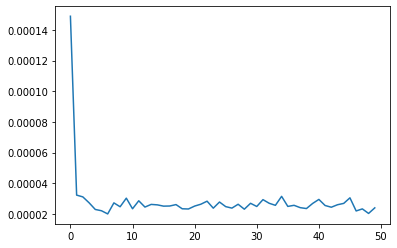

In [ ]:
plt.plot(hist.history['loss'])
plt.show()

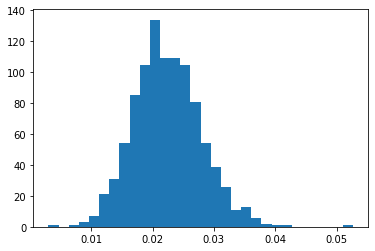

In [ ]:
plt.hist(model.predict(x), bins=30)
plt.show()

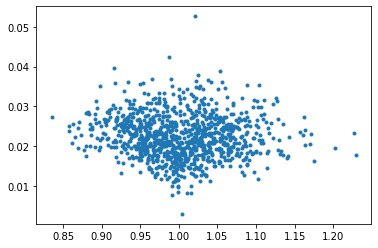

In [ ]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()

In [ ]:
def submodel(m=model):
    submodel_input = m.get_layer("delta_29").input
    submodel_output = m.get_layer("delta_29")(submodel_input)

    return tf.keras.Model(inputs=submodel_input, outputs=submodel_output)

In [ ]:
submodel(model)(np.linspace(0.9,1.1,10))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.4159083e-04],
       [1.0006130e-03],
       [7.0912838e-03],
       [5.0651252e-02],
       [3.3098519e-01],
       [8.7009597e-01],
       [9.5192671e-01],
       [9.8557198e-01],
       [9.9587959e-01],
       [9.9883139e-01]], dtype=float32)>

In [ ]:
scenario = 12
b = []
for j in range(N):
    a = model.get_layer("delta_"+str(j))(S[scenario,j].reshape(1,1))
    b.append(a.numpy().reshape(1,))

In [ ]:
b

[array([0.49036688], dtype=float32),
 array([0.59169304], dtype=float32),
 array([0.60009265], dtype=float32),
 array([0.875259], dtype=float32),
 array([0.64195323], dtype=float32),
 array([0.9557519], dtype=float32),
 array([0.95729166], dtype=float32),
 array([0.93800384], dtype=float32),
 array([0.8471433], dtype=float32),
 array([0.7807895], dtype=float32),
 array([0.60949093], dtype=float32),
 array([0.6802155], dtype=float32),
 array([0.7080469], dtype=float32),
 array([0.7569466], dtype=float32),
 array([0.59616697], dtype=float32),
 array([0.6090219], dtype=float32),
 array([0.38344762], dtype=float32),
 array([0.5797279], dtype=float32),
 array([0.38552648], dtype=float32),
 array([0.5511075], dtype=float32),
 array([0.27579123], dtype=float32),
 array([0.554893], dtype=float32),
 array([0.4461043], dtype=float32),
 array([0.8501504], dtype=float32),
 array([0.71300143], dtype=float32),
 array([0.8810371], dtype=float32),
 array([0.825974], dtype=float32),
 array([0.89580816]

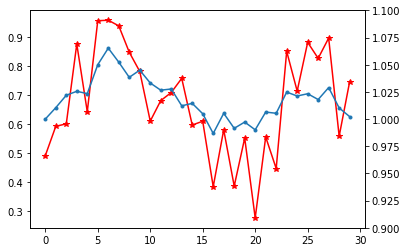

In [ ]:
fig,ax = plt.subplots()
ax.plot(b, marker="*", color='r')
ax2 = ax.twinx()
ax2.plot(S[scenario,:-1], marker=".",)
ax2.set_ylim(0.9,1.1)
plt.show()

In [ ]:
def rnn_delta_model(model_name=None, num=1):
    price = tf.keras.layers.Input(shape=(num,1))
    delta = tf.keras.layers.GRU(32, return_sequences=True)(price)
    delta = tf.keras.layers.GRU(32)(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.Dense(1, activation='sigmoid')(delta)

    return tf.keras.Model(inputs=price, outputs=delta, name=model_name)


In [ ]:
rnn_delta_model(num=100).summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_290 (InputLayer)      [(None, 100, 1)]          0         
                                                                 
 gru_66 (GRU)                (None, 100, 32)           3360      
                                                                 
 gru_67 (GRU)                (None, 32)                6336      
                                                                 
 dense_1156 (Dense)          (None, 32)                1024      
                                                                 
 batch_normalization_578 (Ba  (None, 32)               128       
 tchNormalization)                                               
                                                                 
 dense_1157 (Dense)          (None, 32)                1024      
                                                          

In [ ]:
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = [price]

hedge_cost = tf.keras.layers.Lambda(lambda x: x*0.0)(price)

price_set = tf.keras.layers.Concatenate()([price, price])

for j in range(N):
    delta = rnn_delta_model(model_name="delta_"+str(j), num=2+j)(price_set)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input += [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])

    price_set = tf.keras.layers.Concatenate()([price_set, new_price])

    price = new_price

payoff = tf.keras.layers.Input(shape=(1,), name='payoff')
my_input += [payoff]

cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

In [ ]:
model.compile(loss='mse', optimizer='adam')
hist = model.fit(x,y, batch_size=32, epochs=50, verbose=True, validation_split=0.2)

Epoch 1/50
25/25 [==============================] - 117s 1s/step - loss: 1.3972e-04 - val_loss: 2.7964e-04
Epoch 2/50
25/25 [==============================] - 6s 233ms/step - loss: 5.6668e-05 - val_loss: 2.7964e-04
Epoch 3/50
25/25 [==============================] - 6s 230ms/step - loss: 4.2406e-05 - val_loss: 2.7858e-04
Epoch 4/50
25/25 [==============================] - 6s 229ms/step - loss: 3.8548e-05 - val_loss: 2.7663e-04
Epoch 5/50
25/25 [==============================] - 6s 230ms/step - loss: 4.1045e-05 - val_loss: 2.7336e-04
Epoch 6/50
25/25 [==============================] - 6s 228ms/step - loss: 3.7330e-05 - val_loss: 2.6872e-04
Epoch 7/50
25/25 [==============================] - 6s 231ms/step - loss: 3.0299e-05 - val_loss: 2.6797e-04
Epoch 8/50
25/25 [==============================] - 6s 230ms/step - loss: 3.6546e-05 - val_loss: 2.6262e-04
Epoch 9/50
25/25 [==============================] - 6s 229ms/step - loss: 3.3481e-05 - val_loss: 2.5374e-04
Epoch 10/50
25/25 [==========

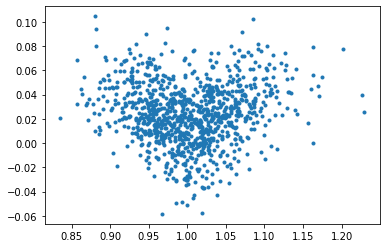

In [ ]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()